# Part 2 (A7) - A: Promotion Analysis

Taso Kinnas

Carry out your proposed research! At the end of this, submit:

* A 5–10 page report with your research questions and results. This should be organized to communicate, without attention to the order in which things need to be run.

* An HTML export of your Jupyter notebook that contains the actual analysis. All figures from your report should appear in this document, in their appropriate computational context.

Notes:  
consider k-means for clustering...
Pearson correlation

Predictive features:
* Seasonality
* Weather
* Location
* Promotions
* Stock
* Television - (commercials?)
* Offline segmentation...


Insightful links:
* https://www.marketwatch.com/story/the-future-of-grocery-shopping-is-all-about-data-2017-10-24 (Amazon spends 12% of its sales on technology each year, compared with less than 3% at most grocers)
* https://medium.com/datalogue/becoming-a-data-cook-1a668b3faf63 (getting data ready for analysis is 80% of a data scientists's time)
* A
* A

 look at
 - splitting out multiple notebooks
 - swap memory (op sys takes care of)
 - write csv and save() and load() for data management with R

 consider consolidatung categories(5-10)
 contour plot (discount, length of time, consider looking at percrnt change in price), ggplot (see Dr. E example on rat tumor)
 heat map

In [1]:
library(tidyverse) # general tidyverse functions

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats


In [2]:
# sets plot height to 3.5 inches
options(repr.plot.height=3.5)

In [3]:
# function to export plots
make.plot = function(name, plot_expr, type="pdf", width, height, ...) {
    dir.create("data/wholefoods/images", recursive = TRUE, showWarnings = FALSE)
    if (identical(type, "pdf")) {
        pdf(sprintf("data/wholefoods/images/%s.pdf", name),
            width=width, height=height, ...)
    } else if (identical(type, "png")) {
        png(sprintf("data/wholefoods/images/%s.png", name),
            width=width, height=height, units="in", res=300, ...)
    } else {
        stop("invalid plot type")
    }
    print(plot_expr)
    dev.off()
    plot_expr
}

## 1. Project goals:

1. Evaluate Brand loyalty:  Do customers switch brands on pricing changes?

## 2. Data Source:

In [4]:
# read data file, convert columns to relevant data types

# filtered on region 7 (pacific northwest)
wfm = read_tsv('data/wholefoods/wfm_final.tsv', col_types="cccccccDddddcccc")

# updated category classifications
cats = read_csv('data/wholefoods/categories.csv', col_types="cccccc")

#Store 10564 appears to be a 'test' store of some sort.
wfm = wfm %>%
    filter(CustNum != 10564)

spec(wfm)
spec(cats)

cols(
  Region = col_character(),
  CustNum = col_character(),
  Store = col_character(),
  Address = col_character(),
  City = col_character(),
  StateAbr = col_character(),
  zip = col_character(),
  Date = col_date(format = ""),
  Sales = col_double(),
  SalesLy = col_double(),
  Units = col_double(),
  UnitsLy = col_double(),
  Brand = col_character(),
  Category = col_character(),
  UPC = col_character(),
  Description = col_character()
)

cols(
  Family_01 = col_character(),
  Category_02 = col_character(),
  Subcategory_03 = col_character(),
  Class_04 = col_character(),
  UPC = col_character(),
  Product = col_character()
)

## 3. Data Summary:

In [5]:
summary(wfm)

    Region            CustNum             Store             Address         
 Length:24366132    Length:24366132    Length:24366132    Length:24366132   
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
     City             StateAbr             zip                 Date           
 Length:24366132    Length:24366132    Length:24366132    Min.   :2016-01-04  
 Class :character   Class :character   Class :character   1st Qu.:2016-04-04  
 Mode  :character   Mode  :character   Mode  :character   Median :2016-07-04  
                                                          Mean   :2016-07-02  
                                                          3rd Qu.:

In [6]:
head(cats)

Family_01,Category_02,Subcategory_03,Class_04,UPC,Product
Grocery Bulk,Baking,Flours,Almond: 48247,1037,ALMOND FLOUR EX FINE
Grocery Frozen,Vegetables,Vegetables,Vegetables: 42648,1162,BULK FROZEN FRUIT AND VEGETABLES
Grocery Bulk,Baking,Flours,Almond: 48247,1173,FLOUR ALMOND MEAL
Grocery Bulk,Cereals Hot,Cereals Hot Archive,Cereals Hot Archive: 48382,1315,CEREAL HOT HIGH FIBER OG
Coffee,Coffee,Bulk Coffee,Bulk Coffee: 45676,1341,TEA YERBA MATE
Grocery Bulk,Functional Snacks,Dried Fruits,Cranberries: 48413,1371,CRANBERRIES SUGAR SWEETENED OG


In [7]:
wfm_cats = wfm %>%
    left_join(cats)

Joining, by = "UPC"


In [8]:
head(wfm_cats)

Region,CustNum,Store,Address,City,StateAbr,zip,Date,Sales,SalesLy,⋯,UnitsLy,Brand,Category,UPC,Description,Family_01,Category_02,Subcategory_03,Class_04,Product
Mid-West,10303,Town and Country,1160 Town and Country Crossin,Town and Country,MO,63017,2016-01-04,0.00,19.96,⋯,4,Bob's Red Mill,Mixes,3997800464,Mix Brownie Gf (21oz),Grocery,"Baking Mixes, Ingredients & Flours",Baking Mixes,Brownie Mix: 46933,MIX BROWNIE GF
Mid-West,10120,West Bloomfield,7350 Orchard Lake Roa,West Bloomfield,MI,48322,2016-01-04,4.99,0.00,⋯,0,Bob's Red Mill,Mixes,3997800464,Mix Brownie Gf (21oz),Grocery,"Baking Mixes, Ingredients & Flours",Baking Mixes,Brownie Mix: 46933,MIX BROWNIE GF
Mid-West,10460,West Des Moines,4100 University Ave Suite #26,West Des Moines,IA,50266,2016-01-04,4.99,0.00,⋯,0,Bob's Red Mill,Mixes,3997800464,Mix Brownie Gf (21oz),Grocery,"Baking Mixes, Ingredients & Flours",Baking Mixes,Brownie Mix: 46933,MIX BROWNIE GF
Mid-West,10572,West Loop,1 N. Halsted Stree,Chicago,IL,60661,2016-01-04,4.99,0.00,⋯,0,Bob's Red Mill,Mixes,3997800464,Mix Brownie Gf (21oz),Grocery,"Baking Mixes, Ingredients & Flours",Baking Mixes,Brownie Mix: 46933,MIX BROWNIE GF
Mid-West,10068,Wheaton,89 Danada Square Eas,Wheaton,IL,60189,2016-01-04,9.98,0.00,⋯,0,Bob's Red Mill,Mixes,3997800464,Mix Brownie Gf (21oz),Grocery,"Baking Mixes, Ingredients & Flours",Baking Mixes,Brownie Mix: 46933,MIX BROWNIE GF
Mid-West,10573,Willowbrook,6300 S. Robert Kingery Highwa,Willowbrook,IL,60527,2016-01-04,4.99,0.00,⋯,0,Bob's Red Mill,Mixes,3997800464,Mix Brownie Gf (21oz),Grocery,"Baking Mixes, Ingredients & Flours",Baking Mixes,Brownie Mix: 46933,MIX BROWNIE GF


In [9]:
wfm_cats = wfm_cats %>%
    filter(Category_02 != "NA")

In [10]:
wfmtest = wfm_cats %>% 
    group_by(Brand, UPC, Category, Category_02) %>%
    summarize(sum=sum(Sales)) %>%
    arrange(Category_02)
tail(wfmtest)

Brand,UPC,Category,Category_02,sum
Straus Family Creamery,78483000083,Yogurt,Yogurt,2193.63
Straus Family Creamery,78483000084,Yogurt,Yogurt,43685.89
Straus Family Creamery,78483000086,Yogurt,Yogurt,204461.91
Straus Family Creamery,78483000177,Yogurt,Yogurt,66012.19
Straus Family Creamery,78483000400,Yogurt,Yogurt,994079.13
Straus Family Creamery,78483000410,Yogurt,Yogurt,395642.13


# Inital Data Summary 

#### What categories have the most brands in the dataset?

In [11]:
brandcat = wfm_cats %>%
    group_by(Family_01) %>%
    distinct(Brand) %>%
    select(-Brand) %>%
    summarize(count=n()) %>%
    arrange(-count) 
brandcat

Family_01,count
Grocery,33
Grocery Dairy,13
Grocery Frozen,11
Grocery Bulk,10
Supplements,7
Body Care,6
Unidentified Items,5
Bakery,3
Beer,2
Specialty Cheese,2


#### What are the top selling categories in sales?

In [12]:
wfm_sales_by_category = wfm_cats %>%
    group_by(Family_01) %>%
    summarize(salesTY=sum(Sales), unitsTY=sum(Units), 
              salesLY=sum(SalesLy), unitsLY=sum(UnitsLy),
              CpU_TY=sum(Sales)/sum(Units), CpU_LY=sum(SalesLy)/sum(UnitsLy)) %>%
    arrange(-salesTY) %>%
    mutate(c_rank=row_number())
head(wfm_sales_by_category)

Family_01,salesTY,unitsTY,salesLY,unitsLY,CpU_TY,CpU_LY,c_rank
Grocery,261175044,70345836,261364883,70853975,3.712729,3.688782,1
Grocery Dairy,118542269,37064240,111137674,35697726,3.198292,3.113298,2
Grocery Frozen,73593300,15923307,69697151,15338613,4.621735,4.543902,3
Body Care,51820272,6422559,51455437,6351864,8.068478,8.100841,4
Supplements,23703480,2663321,26085147,2890217,8.899971,9.025325,5
Grocery Bulk,15580016,4372518,18012029,5001788,3.563168,3.601118,6


#### The category ranking with count of brands.

In [13]:
brandcat_rank = brandcat %>%
    inner_join(wfm_sales_by_category) %>%
    arrange(c_rank)
head(brandcat_rank)

Joining, by = "Family_01"


Family_01,count,salesTY,unitsTY,salesLY,unitsLY,CpU_TY,CpU_LY,c_rank
Grocery,33,261175044,70345836,261364883,70853975,3.712729,3.688782,1
Grocery Dairy,13,118542269,37064240,111137674,35697726,3.198292,3.113298,2
Grocery Frozen,11,73593300,15923307,69697151,15338613,4.621735,4.543902,3
Body Care,6,51820272,6422559,51455437,6351864,8.068478,8.100841,4
Supplements,7,23703480,2663321,26085147,2890217,8.899971,9.025325,5
Grocery Bulk,10,15580016,4372518,18012029,5001788,3.563168,3.601118,6


#### Using category with most brands (snacks) and getting sales/unit summaries by week and calculating cost per unit

In [34]:
wfm_sales_date_category = wfm_cats %>%  
    filter(Family_01 == "Supplements") %>%
    filter(Category_02 == "Sports Nutrition and Weight Management") %>%
    group_by(Date, Category_02, Brand) %>%
    summarize(WsalesTY=sum(Sales), WunitsTY=sum(Units), 
              WsalesLY=sum(SalesLy), WunitsLY=sum(UnitsLy),
              WCpU_TY=sum(Sales)/sum(Units), WCpU_LY=sum(SalesLy)/sum(UnitsLy))
head(wfm_sales_date_category)

Date,Category_02,Brand,WsalesTY,WunitsTY,WsalesLY,WunitsLY,WCpU_TY,WCpU_LY
2016-01-04,Sports Nutrition and Weight Management,Amazing Grass,36321.50,3551,42539.58,3499,10.228527,12.157639
2016-01-04,Sports Nutrition and Weight Management,Bob's Red Mill,2163.40,206,2660.27,223,10.501942,11.929462
2016-01-04,Sports Nutrition and Weight Management,Guayaki,25813.04,7184,25349.58,6053,3.593129,4.187937
2016-01-04,Sports Nutrition and Weight Management,Tera's Whey,80086.37,5978,88063.21,5615,13.396850,15.683564
2016-01-11,Sports Nutrition and Weight Management,Amazing Grass,20060.64,2052,53027.71,3947,9.776140,13.434940
2016-01-11,Sports Nutrition and Weight Management,Bob's Red Mill,2184.94,180,2427.59,201,12.138556,12.077562


In [35]:
am_grass = wfm_sales_date_category %>%
    filter(Brand == "Tera's Whey")
#am_grass
summary(am_grass)

      Date            Category_02           Brand              WsalesTY     
 Min.   :2016-01-04   Length:52          Length:52          Min.   : 35159  
 1st Qu.:2016-04-02   Class :character   Class :character   1st Qu.: 54396  
 Median :2016-06-30   Mode  :character   Mode  :character   Median : 58535  
 Mean   :2016-06-30                                         Mean   : 63983  
 3rd Qu.:2016-09-27                                         3rd Qu.: 74121  
 Max.   :2016-12-26                                         Max.   :109901  
    WunitsTY       WsalesLY        WunitsLY       WCpU_TY         WCpU_LY     
 Min.   :1919   Min.   :31388   Min.   :1598   Min.   :13.40   Min.   :11.79  
 1st Qu.:3100   1st Qu.:43552   1st Qu.:2448   1st Qu.:15.78   1st Qu.:15.15  
 Median :3434   Median :49280   Median :3050   Median :17.43   Median :16.29  
 Mean   :3814   Mean   :54718   Mean   :3453   Mean   :17.20   Mean   :16.58  
 3rd Qu.:4694   3rd Qu.:64760   3rd Qu.:4249   3rd Qu.:18.36   3rd

In [46]:
am_grass = wfm_sales_date_category %>%
    filter(Brand == "Amazing Grass")
#am_grass
summary(am_grass)

      Date            Category_02           Brand              WsalesTY    
 Min.   :2016-01-04   Length:52          Length:52          Min.   :13576  
 1st Qu.:2016-04-02   Class :character   Class :character   1st Qu.:26048  
 Median :2016-06-30   Mode  :character   Mode  :character   Median :35624  
 Mean   :2016-06-30                                         Mean   :37646  
 3rd Qu.:2016-09-27                                         3rd Qu.:48734  
 Max.   :2016-12-26                                         Max.   :75899  
    WunitsTY       WsalesLY        WunitsLY       WCpU_TY      
 Min.   :1116   Min.   :15178   Min.   :1550   Min.   : 7.726  
 1st Qu.:1874   1st Qu.:25002   1st Qu.:2031   1st Qu.:12.643  
 Median :2518   Median :36511   Median :2812   Median :13.912  
 Mean   :2906   Mean   :36365   Mean   :2966   Mean   :13.429  
 3rd Qu.:3433   3rd Qu.:47573   3rd Qu.:3844   3rd Qu.:14.533  
 Max.   :6847   Max.   :60127   Max.   :4652   Max.   :16.693  
    WCpU_LY      
 M

# Category Graphs

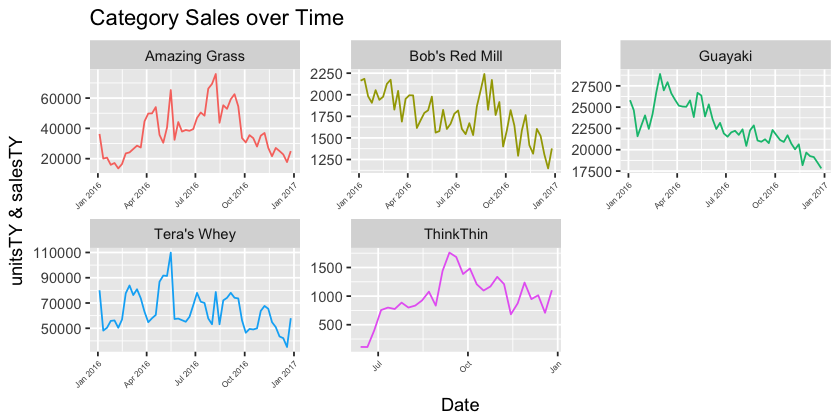

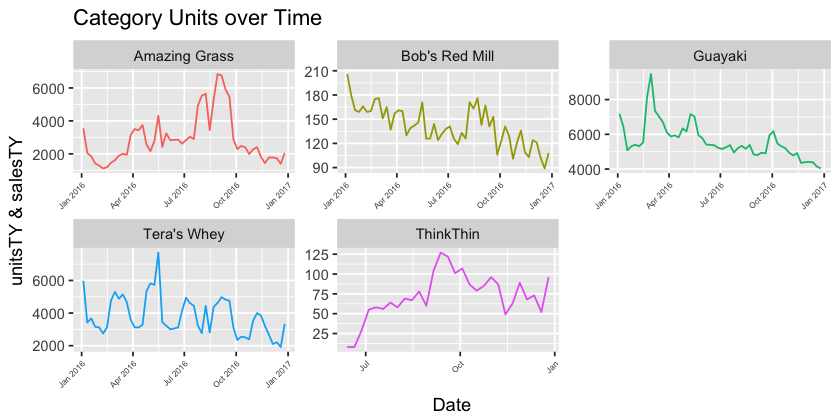

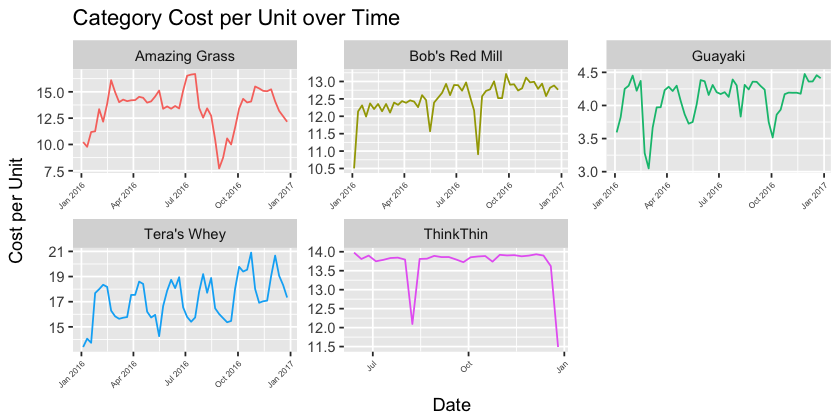

In [37]:
salesplot_category = ggplot(wfm_sales_date_category, aes(x=Date, y=WsalesTY, color=Brand)) +
    geom_line(aes(x=Date, y=WsalesTY, color=Brand)) +
    theme(axis.text.x = element_text(size=5, angle=45, hjust=1), legend.position="none") +
    labs(title="Category Sales over Time", y="unitsTY & salesTY") +
    facet_wrap(~Brand, scales="free")

unitsplot_category = ggplot(wfm_sales_date_category, aes(x=Date, y=WunitsTY, color=Brand, legend.position="none")) +
    geom_line(aes(x=Date, y=WunitsTY, color=Brand)) +
    theme(axis.text.x = element_text(size=5, angle=45, hjust=1), legend.position="none") +
    labs(title="Category Units over Time", y="unitsTY & salesTY") +
    facet_wrap(~Brand, scales="free")

cpuplot_category = ggplot(wfm_sales_date_category, aes(x=Date, y=WCpU_TY, color=Brand, legend.position="none")) +
    geom_line() +
    theme(axis.text.x = element_text(size=5, angle=45, hjust=1), legend.position="none") +
    labs(title="Category Cost per Unit over Time", y="Cost per Unit") +
    facet_wrap(~Brand, scales="free")

salesplot_category
unitsplot_category
cpuplot_category

In [38]:
total_weekly_units = wfm_sales_date_category %>%
    group_by(Date) %>%
    summarize(total_units = sum(WunitsTY))
head(total_weekly_units)

Date,total_units
2016-01-04,16919
2016-01-11,12097
2016-01-18,10764
2016-01-25,10045
2016-02-01,9973
2016-02-08,9338


In [39]:
wfm_unit_sales_ratio = wfm_sales_date_category %>%
    inner_join(total_weekly_units) %>%
    mutate(ratio = 100*WunitsTY/total_units)
head(wfm_unit_sales_ratio)

Joining, by = "Date"


Date,Category_02,Brand,WsalesTY,WunitsTY,WsalesLY,WunitsLY,WCpU_TY,WCpU_LY,total_units,ratio
2016-01-04,Sports Nutrition and Weight Management,Amazing Grass,36321.50,3551,42539.58,3499,10.228527,12.157639,16919,20.988238
2016-01-04,Sports Nutrition and Weight Management,Bob's Red Mill,2163.40,206,2660.27,223,10.501942,11.929462,16919,1.217566
2016-01-04,Sports Nutrition and Weight Management,Guayaki,25813.04,7184,25349.58,6053,3.593129,4.187937,16919,42.461138
2016-01-04,Sports Nutrition and Weight Management,Tera's Whey,80086.37,5978,88063.21,5615,13.396850,15.683564,16919,35.333058
2016-01-11,Sports Nutrition and Weight Management,Amazing Grass,20060.64,2052,53027.71,3947,9.776140,13.434940,12097,16.962883
2016-01-11,Sports Nutrition and Weight Management,Bob's Red Mill,2184.94,180,2427.59,201,12.138556,12.077562,12097,1.487972


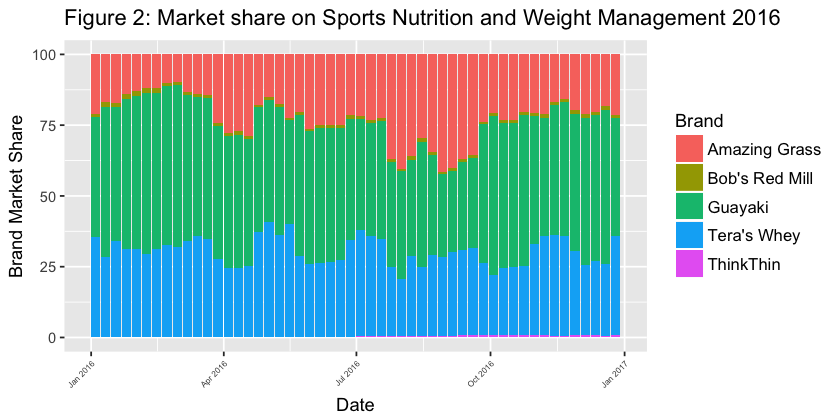

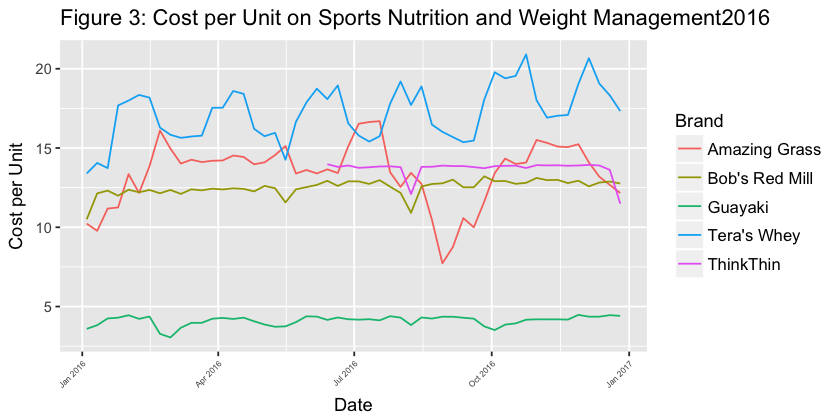

In [48]:
ratio_plot = ggplot(wfm_unit_sales_ratio, aes(x=Date, y=ratio, fill=Brand)) +
    geom_bar(stat="identity") + #, position="dodge") +
    theme(axis.text.x = element_text(size=5, angle=45, hjust=1), legend.text=element_text(size=10)) +
    labs(title="Figure 2: Market share on Sports Nutrition and Weight Management 2016", y="Brand Market Share")

ratio_cpu_plot = ggplot(wfm_unit_sales_ratio, aes(x=Date, y=WCpU_TY, color=Brand)) +
    geom_line() +
    theme(axis.text.x = element_text(size=5, angle=45, hjust=1), legend.text=element_text(size=10)) +
    labs(title="Figure 3: Cost per Unit on Sports Nutrition and Weight Management2016", y="Cost per Unit")

make.plot("market_share",ratio_plot)
make.plot("cost_per_unit",ratio_cpu_plot)

# UPC Data

#### What are the top selling products?

In [41]:
wfm_sales_by_product = wfm_cats %>%
    group_by(UPC) %>%
    summarize(salesTY=sum(Sales), unitsTY=sum(Units), 
              salesLY=sum(SalesLy), unitsLY=sum(UnitsLy),
              CpU_TY=sum(Sales)/sum(Units), CpU_LY=sum(SalesLy)/sum(UnitsLy)) %>%
    arrange(-salesTY) %>%
    mutate(u_rank=row_number())
head(wfm_sales_by_product)

UPC,salesTY,unitsTY,salesLY,unitsLY,CpU_TY,CpU_LY,u_rank
72243020016,7767070,2303049,7431070,2244725,3.372516,3.310459,1
72243011016,5365149,1592594,4820165,1474019,3.368811,3.270084,2
89044400029,5016470,1460658,5666209,1659272,3.434391,3.414876,3
85358400201,4303225,744832,4064564,681280,5.777444,5.966069,4
72243060016,3267717,969275,2999601,917759,3.371300,3.268397,5
72243014016,3220793,951691,3239495,976598,3.384284,3.317122,6


#### Added calculated columns by week

In [42]:
wfm_sales_date_product = wfm_cats %>%  
    group_by(Date, UPC, Product) %>%
    summarize(WsalesTY=sum(Sales), WunitsTY=sum(Units), 
              WsalesLY=sum(SalesLy), WunitsLY=sum(UnitsLy),
              WCpU_TY=sum(Sales)/sum(Units), WCpU_LY=sum(SalesLy)/sum(UnitsLy))
head(wfm_sales_date_product)

Date,UPC,Product,WsalesTY,WunitsTY,WsalesLY,WunitsLY,WCpU_TY,WCpU_LY
2016-01-04,1037,ALMOND FLOUR EX FINE,54.00,6.36,0.00,0.00,8.490566,NaN
2016-01-04,1162,BULK FROZEN FRUIT AND VEGETABLES,759.93,190.45,212.28,53.21,3.990181,3.989476
2016-01-04,1173,FLOUR ALMOND MEAL,16830.65,1499.19,21096.73,2347.35,11.226496,8.987467
2016-01-04,1315,CEREAL HOT HIGH FIBER OG,2.49,1.00,13.20,5.75,2.490000,2.295652
2016-01-04,1341,TEA YERBA MATE,12.61,0.97,16.64,1.28,13.000000,13.000000
2016-01-04,1371,CRANBERRIES SUGAR SWEETENED OG,73.88,7.42,1455.27,145.64,9.956873,9.992241


#### Join annual product sales and weekly product sales for ranking for graph

In [43]:
# calculate sales per unit for top 5 products
top_5_upc = wfm_sales_by_product %>%
    select(UPC, u_rank) %>%
    inner_join(wfm_sales_date_product) %>%
    filter(u_rank<=5)
head(top_5_upc)

Joining, by = "UPC"


UPC,u_rank,Date,Product,WsalesTY,WunitsTY,WsalesLY,WunitsLY,WCpU_TY,WCpU_LY
72243020016,1,2016-01-04,KOMBUCHA ENLIGHTENED GINGERADE OG,154864.0,48970,136050.0,41248,3.162426,3.298341
72243020016,1,2016-01-11,KOMBUCHA ENLIGHTENED GINGERADE OG,150132.5,49892,130049.7,37581,3.009149,3.460518
72243020016,1,2016-01-18,KOMBUCHA ENLIGHTENED GINGERADE OG,138682.5,42989,140721.7,40638,3.226000,3.462811
72243020016,1,2016-01-25,KOMBUCHA ENLIGHTENED GINGERADE OG,152422.1,46096,158862.9,53461,3.306623,2.971566
72243020016,1,2016-02-01,KOMBUCHA ENLIGHTENED GINGERADE OG,154737.6,46880,171686.4,60042,3.300717,2.859439
72243020016,1,2016-02-08,KOMBUCHA ENLIGHTENED GINGERADE OG,178791.1,60580,139592.3,43950,2.951322,3.176162


#### Plot Graphs

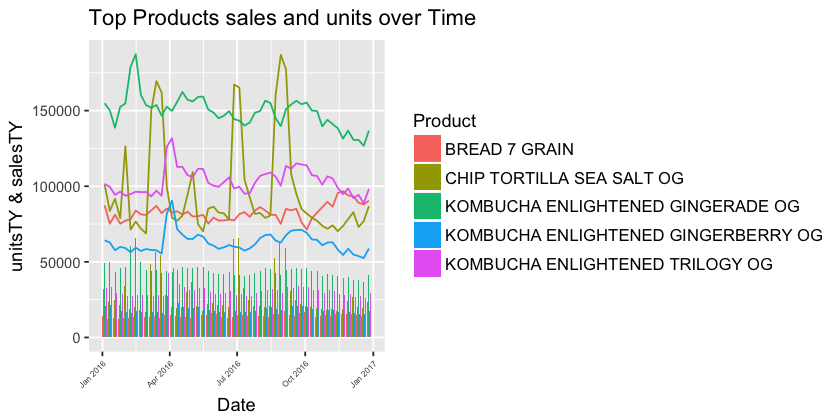

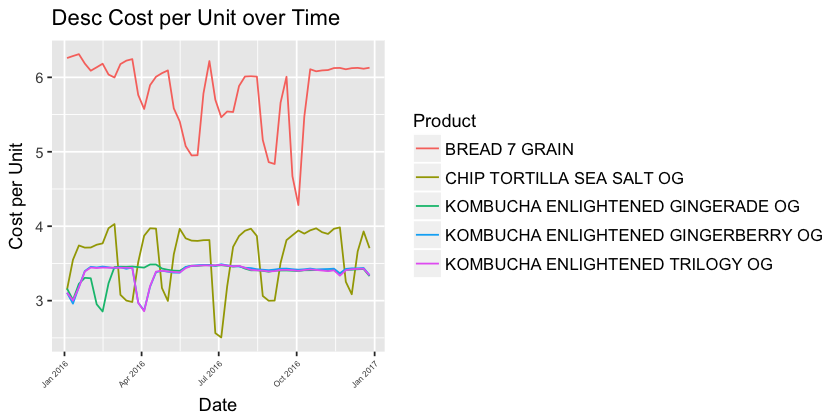

In [44]:
# plot of sales and units for top 5 products by product description
fancyplot_desc = ggplot(top_5_upc, aes(x=Date, y=WunitsTY, fill=Product)) +
    geom_bar(stat="identity", position="dodge") +
    geom_line(aes(x=Date, y=WsalesTY, color=Product)) +
    theme(axis.text.x = element_text(size=5, angle=45, hjust=1), legend.text=element_text(size=10)) +
    labs(title="Top Products sales and units over Time", y="unitsTY & salesTY")

# plot of cost per unit for top 5 products by product description
cpuplot_desc = ggplot(top_5_upc, aes(x=Date, y=WCpU_TY, color=Product)) +
    geom_line() +
    theme(axis.text.x = element_text(size=5, angle=45, hjust=1), legend.text=element_text(size=10)) +
    labs(title="Desc Cost per Unit over Time", y="Cost per Unit")

fancyplot_desc
cpuplot_desc